## thanks to Nicolo 
https://towardsdatascience.com/fine-tuning-bert-for-text-classification-54e7df642894#8f53


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tiktok_text_processing
import ml_utils

from tabulate import tabulate
from tqdm import trange
import random

## Dataset

In [2]:
file_path = '../data/comments_anonymous.csv'

df = pd.read_csv(file_path)
df.head()

,_id,comment,offensive
0,62cfdd36dcebc86793aa9534,bro im not aa im literally african my tribe co...,0
1,62cfdda0dcebc86793aaee87,It drives me crazy! It’s such a struggle eithe...,0
2,62cfde28dcebc86793ab60dc,So why they making a big deal,0
3,62cfdd8bdcebc86793aadc15,There’s nothing that makes it any better. We h...,0
4,62cfddacdcebc86793aaf7bf,"Simply put, fascism needs to be fought against...",0


In [3]:
df['comment'] = df['comment'].apply(ml_utils.remove_links)
df['comment'] = df['comment'].apply(tiktok_text_processing.replace_slang)

,_id,comment,offensive
0,62cfdd36dcebc86793aa9534,bro im not aa im lossiteralosslossy african my...,0
1,62cfdda0dcebc86793aaee87,It drives me crazy! It’s such a strugglosse ei...,0
2,62cfde28dcebc86793ab60dc,So winhy they making a big dealoss,0
3,62cfdd8bdcebc86793aadc15,There’s nothing that makes it any better. We h...,0
4,62cfddacdcebc86793aaf7bf,"Simplossy put, fascism needs to be fought agai...",0


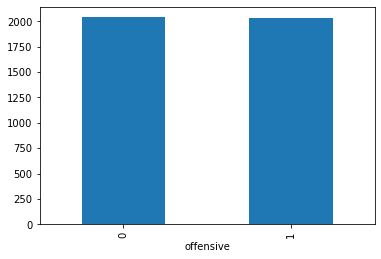

In [4]:
comments  = df.comment.values
labels = df.offensive.values
df.groupby(['offensive']).size().plot.bar()
df.head()

## Preprocessing
We use bert-base-uncased because most comments don't use capital letters for NE + we are not interested in NER (Named enity recognition) anyway

In [17]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [18]:
tiktok_text_processing.add_emoji_tokens(tokenizer)

AttributeError: module 'tiktok_text_processing' has no attribute 'add_emoji'

In [6]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(comments)-1)
  table = np.array([tokenizer.tokenize(comments[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(comments[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ al       │        2632 │
├──────────┼─────────────┤
│ ##oss    │       15094 │
├──────────┼─────────────┤
│ ##los    │       10483 │
├──────────┼─────────────┤
│ ##s      │        2015 │
├──────────┼─────────────┤
│ loss     │        3279 │
├──────────┼─────────────┤
│ ##ives   │       24653 │
├──────────┼─────────────┤
│ matter   │        3043 │
├──────────┼─────────────┤
│ win      │        2663 │
├──────────┼─────────────┤
│ ##as     │        3022 │
├──────────┼─────────────┤
│ a        │        1037 │
├──────────┼─────────────┤
│ saying   │        3038 │
├──────────┼─────────────┤
│ made     │        2081 │
├──────────┼─────────────┤
│ to       │        2000 │
├──────────┼─────────────┤
│ de       │        2139 │
├──────────┼─────────────┤
│ ##grade  │       24170 │
├──────────┼─────────────┤
│ b        │        1038 │
├──────────┼─────────────┤
│ ##los    │       10483 │
├──────────┼─────────────┤
│

In [7]:
comment_lenghts = [len(comment) for comment in comments]
comment_len_mean = np.mean(comment_lenghts)
comment_len_avg = np.average(comment_lenghts)
comment_max_len = np.max(comment_lenghts)

print(comment_len_avg)
print(comment_len_mean)
print(comment_max_len)

70.69555610115394
70.69555610115394
322


In [8]:
print('Max sentence length: ', max([len(comment) for comment in comments]))

Max sentence length:  322


In [9]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = comment_max_len,
                        pad_to_max_length = True,
                        padding='max_length',
                        return_attention_mask = True,
                        truncation = True,
                        return_tensors = 'pt'
                   )


for sample in comments:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

In [10]:
token_id[6]

tensor([  101,  2273, 25931, 15094, 10483,  2015,  2031,  2062, 14163, 11020,
        10483,  3366,  3742,  1010,  1998,  2006,  2779,  2024,  6428,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [11]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(comments) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ dude     │       12043 │                1 │
├──────────┼─────────────┼──────────────────┤
│ cried    │        6639 │                1 │
├──────────┼─────────────┼──────────────────┤
│ in       │        1999 │                1 │
├──────────┼─────────────┼──────────────────┤
│ court    │        2457 │                1 │
├──────────┼─────────────┼──────────────────┤
│ for      │        2005 │                1 │
├──────────┼─────────────┼──────────────────┤
│ getting  │        2893 │                1 │
├──────────┼─────────────┼──────────────────┤
│ loss     │        3279 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##ike    │       17339 │                1 │
├──────────┼─────────────┼──────────────────┤
│ 3        │        1017 │        

In [12]:
# Defines ratios, w.r.t. whole dataset.
train_ratio = 0.8
val_ratio = 0.2
test_ratio = 0.15

# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 8

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

#new_test_ratio = np.around(test_ratio / (val_ratio + test_ratio), 2)
# To preserve (new_test_ratio + new_val_ratio) = 1.0 
#new_val_ratio = 1.0 - new_test_ratio

#val_idx, test_idx = train_test_split(remain_idx, test_size=new_test_ratio)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

#test_set = TensorDataset(token_id[test_idx], 
 #                       attention_masks[test_idx], 
  #                      labels[test_idx])


# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

#test_dataloader = DataLoader(
 #           test_set,
  #          sampler = SequentialSampler(test_set),
   #         batch_size = batch_size
    #    )


In [13]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [14]:
# clear cache on re-run
import torch, gc
gc.collect()
torch.cuda.empty_cache()

# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [15]:

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 3

training_results=[]

for _ in trange(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids, 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
        
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids, 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    training_results.append({
        'accuracy':'{:.4f}'.format(sum(val_accuracy)/len(val_accuracy)),
        'precision':'{:.4f}'.format(sum(val_precision)/len(val_precision)),
        'recall':'{:.4f}'.format(sum(val_recall)/len(val_recall)),
        'specificity':'{:.4f}'.format(sum(val_specificity)/len(val_specificity))
    })
    

Epoch:  33%|███▎      | 1/3 [03:14<06:28, 194.20s/it]


	 - Train loss: 0.5587
	 - Validation Accuracy: 0.7719
	 - Validation Precision: 0.7332
	 - Validation Recall: 0.8855
	 - Validation Specificity: 0.6638



Epoch:  67%|██████▋   | 2/3 [06:27<03:13, 193.55s/it]


	 - Train loss: 0.3412
	 - Validation Accuracy: 0.7756
	 - Validation Precision: 0.8760
	 - Validation Recall: 0.6473
	 - Validation Specificity: 0.9127



Epoch: 100%|██████████| 3/3 [09:40<00:00, 193.38s/it]


	 - Train loss: 0.1877
	 - Validation Accuracy: 0.7694
	 - Validation Precision: 0.7210
	 - Validation Recall: 0.8749
	 - Validation Specificity: 0.6952



## Predict

In [ ]:
training_results

[{'accuracy': '0.7792',
  'precision': '0.7467',
  'recall': '0.8650',
  'specificity': '0.7039'},
 {'accuracy': '0.7841',
  'precision': '0.8792',
  'recall': '0.6648',
  'specificity': '0.9133'},
 {'accuracy': '0.7904',
  'precision': '0.8171',
  'recall': '0.7505',
  'specificity': '0.8377'}]

In [ ]:
new_sentence = 'How do you make a dead coon float? Take your foot off its head and let it rise to the surface asshole'

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Offensive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not offensive'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  How do you make a dead coon float? Take your foot off its head and let it rise to the surface asshole
Predicted Class:  Offensive


In [ ]:
new_sentence = "cap"

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Offensive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Not offensive'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  cap
Predicted Class:  Offensive


In [ ]:
training_results

[{'accuracy': '0.7792',
  'precision': '0.7467',
  'recall': '0.8650',
  'specificity': '0.7039'},
 {'accuracy': '0.7841',
  'precision': '0.8792',
  'recall': '0.6648',
  'specificity': '0.9133'},
 {'accuracy': '0.7904',
  'precision': '0.8171',
  'recall': '0.7505',
  'specificity': '0.8377'}]

In [ ]:
import time
timestr = time.strftime("%Y%m%d_%H%M%S")
#todo save results as well
torch.save(model.state_dict(),'models/'+timestr+'_offensive.bak')

In [ ]:
import json
# Serializing json
json_object = json.dumps(training_results, indent=4)
 
# Writing to sample.json
with open('models/'+timestr + "offensive.json", "w") as outfile:
    outfile.write(json_object)